In [1]:
import pandas as pd
df = pd.read_csv("海康威视.csv")
# print(df)
df.dropna(inplace=True)
pre_days = 10
df=df.set_index(['date'])
df

,open,close,high,low,volume,code
date,,,,,,
2010-05-28,-1.039,-0.821,-0.761,-1.101,340983.54,2415
2010-05-31,-0.601,-0.650,-0.496,-0.733,172278.73,2415
2010-06-01,-0.594,-0.525,-0.483,-0.696,109946.80,2415
2010-06-02,-0.678,-0.589,-0.572,-0.804,94962.64,2415
2010-06-03,-0.594,-0.839,-0.551,-0.872,75605.22,2415
...,...,...,...,...,...,...
2023-05-31,35.170,34.860,35.480,34.600,257120.00,2415
2023-06-01,34.890,35.900,36.400,34.440,507622.00,2415
2023-06-02,35.900,35.910,36.080,35.480,296013.00,2415


In [2]:
def Stock_Price_LSTM_Data_precesing(df,mem_his_days,pro_days):
#     df=df.set_index(['date'])
    df=df.dropna() # 注意删除空值
#     df=df.drop('code',axis=1)
    df['label'] = df.loc[:, 'close'].shift(-pre_days).copy()

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:,:-1])
#     print(sca_X)

    # 使用队列
    from collections import deque
    deq = deque(maxlen=mem_his_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    # 特征向量空间
    X = X[:-pre_days]
#     print(len(X))
#     print(X[0])
#     print(len(X_lately))

    y=df['label'].values[mem_his_days-1:-pre_days]
#     print(len(y))
#     print(y)
    import numpy as np
    X = np.array(X)
    y = np.array(y)
#     print(X.shape)
#     print(y.shape)
    return df,X,y,X_lately

In [3]:
# df,X,y,X_lately = Stock_Price_LSTM_Data_precesing(df,5,10)
# print(df.index)
# print(X[0])
# print(y)
# print(len(X_lately))

In [16]:
# mem_days=[5,10,15]
# lstm_layers=[1,2,3]
# dense_layers = [1,2,3]
# units = [8,16,32]# 神经元
mem_days=[5]
lstm_layers=[2]
dense_layers = [2]
units = [8]# 神经元
# 5.55_07_men_5_lstm_2_dense_2_unit_8
# 模型优化 自动训练寻找最优模型
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = '..\models\{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape', # 这里使用平均误差率  val_accuracy（准确率）（主要用于分类）
                    mode='min',# 平均误差率越小越好
                    save_best_only=True)
                
                df,X,y,X_lately = Stock_Price_LSTM_Data_precesing(df,the_mem_days,pre_days)
                from sklearn.model_selection import train_test_split
                X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                
                 # 构建神经网络
                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                # 三层：lstm，Dense，删除部分神经元
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                model = Sequential()
                # 激活函数relu，循环神经网络要求第一个return
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                # 防止过拟合，删除0.1%的神经元
                model.add(Dropout(0,1))

                for i in range(the_lstm_layers):
                    # 此处input_shape由上一层决定
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0,1))
                    
                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0,1))
                # 构建全连接层
                for i in range(the_dense_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0,1))
                # 输出层，只输出一个值
                model.add(Dense(1))
                # 编译
                model.compile(optimizer='adam',# 优化器
                             loss='mse',# 损失函数（此处要求回归）
                             metrics=['mape'])# 评价函数（此处要求回归） MAPE 平均绝对百分比误差
                # 训练模型 训练数据集，32，50期训练，校验数据集
                print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
                model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[checkpoint])     

C:\Users\24613\AppData\Local\Temp\ipykernel_9316\4174158026.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.loc[:, 'close'].shift(-pre_days).copy()


(2039, 5, 6) (2039,) (227, 5, 6) (227,)
Epoch 1/50
62/64 [============================>.] - ETA: 0s - loss: 225.0692 - mape: 106.3496

INFO:tensorflow:Assets written to: ..\models\98.08_01_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\98.08_01_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 14s 135ms/step - loss: 224.1952 - mape: 106.6641 - val_loss: 759.9286 - val_mape: 98.0758
Epoch 2/50
61/64 [===========================>..] - ETA: 0s - loss: 100.7880 - mape: 248.7807

INFO:tensorflow:Assets written to: ..\models\18.79_02_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\18.79_02_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 125ms/step - loss: 97.9756 - mape: 248.2484 - val_loss: 44.0030 - val_mape: 18.7853
Epoch 3/50
61/64 [===========================>..] - ETA: 0s - loss: 20.3092 - mape: 306.6060

INFO:tensorflow:Assets written to: ..\models\12.33_03_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\12.33_03_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 123ms/step - loss: 19.9116 - mape: 299.4402 - val_loss: 16.5085 - val_mape: 12.3264
Epoch 4/50
61/64 [===========================>..] - ETA: 0s - loss: 6.4552 - mape: 171.1523

INFO:tensorflow:Assets written to: ..\models\10.05_04_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\10.05_04_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 122ms/step - loss: 6.3851 - mape: 169.8190 - val_loss: 10.4995 - val_mape: 10.0473
Epoch 5/50
61/64 [===========================>..] - ETA: 0s - loss: 4.0210 - mape: 94.7030

INFO:tensorflow:Assets written to: ..\models\9.42_05_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\9.42_05_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 7s 118ms/step - loss: 3.9721 - mape: 94.0698 - val_loss: 9.2815 - val_mape: 9.4197
Epoch 6/50
61/64 [===========================>..] - ETA: 0s - loss: 3.1429 - mape: 58.9037

INFO:tensorflow:Assets written to: ..\models\8.94_06_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\8.94_06_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 121ms/step - loss: 3.1457 - mape: 58.9366 - val_loss: 8.4512 - val_mape: 8.9394
Epoch 7/50
61/64 [===========================>..] - ETA: 0s - loss: 2.7566 - mape: 54.3230

INFO:tensorflow:Assets written to: ..\models\8.66_07_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\8.66_07_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 123ms/step - loss: 2.7934 - mape: 55.7567 - val_loss: 8.0907 - val_mape: 8.6647
Epoch 8/50
64/64 [==============================] - 1s 10ms/step - loss: 2.6105 - mape: 54.8943 - val_loss: 8.3455 - val_mape: 8.7351
Epoch 9/50
64/64 [==============================] - 1s 10ms/step - loss: 2.5433 - mape: 51.5000 - val_loss: 8.1187 - val_mape: 8.8248
Epoch 10/50
64/64 [==============================] - 1s 10ms/step - loss: 2.5464 - mape: 53.4225 - val_loss: 8.1929 - val_mape: 8.6760
Epoch 11/50
64/64 [==============================] - 1s 10ms/step - loss: 2.4276 - mape: 48.6820 - val_loss: 8.4080 - val_mape: 8.7428
Epoch 12/50
64/64 [==============================] - 1s 10ms/step - loss: 2.4656 - mape: 49.5210 - val_loss: 8.1738 - val_mape: 8.7968
Epoch 13/50
64/64 [==============================] - 1s 10ms/step - loss: 2.4520 - mape: 46.4555 - val_loss: 8.4210 - val_mape: 8.9226
Epoch 14/50
61/64 [===========================>..] - ETA: 0s - loss:

INFO:tensorflow:Assets written to: ..\models\8.64_14_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\8.64_14_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 123ms/step - loss: 2.3433 - mape: 46.2472 - val_loss: 8.3690 - val_mape: 8.6422
Epoch 15/50
61/64 [===========================>..] - ETA: 0s - loss: 2.4642 - mape: 44.7790

INFO:tensorflow:Assets written to: ..\models\8.52_15_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\8.52_15_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 7s 118ms/step - loss: 2.4737 - mape: 44.8696 - val_loss: 7.6336 - val_mape: 8.5186
Epoch 16/50
64/64 [==============================] - 1s 10ms/step - loss: 2.4165 - mape: 42.9793 - val_loss: 7.8685 - val_mape: 8.7840
Epoch 17/50
64/64 [==============================] - 1s 10ms/step - loss: 2.2867 - mape: 44.4158 - val_loss: 10.2603 - val_mape: 9.2029
Epoch 18/50
64/64 [==============================] - 1s 10ms/step - loss: 2.3127 - mape: 44.3400 - val_loss: 8.6969 - val_mape: 8.6184
Epoch 19/50
64/64 [==============================] - 1s 10ms/step - loss: 2.2723 - mape: 40.8451 - val_loss: 7.7057 - val_mape: 8.6734
Epoch 20/50
64/64 [==============================] - 1s 10ms/step - loss: 2.4211 - mape: 39.7742 - val_loss: 9.6462 - val_mape: 9.9115
Epoch 21/50
64/64 [==============================] - 1s 10ms/step - loss: 2.4502 - mape: 38.7362 - val_loss: 8.4105 - val_mape: 8.5514
Epoch 22/50
64/64 [==============================] - 1s 10ms/step

INFO:tensorflow:Assets written to: ..\models\8.49_24_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\8.49_24_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 120ms/step - loss: 2.2270 - mape: 37.6755 - val_loss: 7.6952 - val_mape: 8.4851
Epoch 25/50
64/64 [==============================] - 1s 10ms/step - loss: 2.2400 - mape: 36.6185 - val_loss: 8.6709 - val_mape: 8.6292
Epoch 26/50
64/64 [==============================] - 1s 10ms/step - loss: 2.2371 - mape: 35.4451 - val_loss: 7.8773 - val_mape: 8.5238
Epoch 27/50
64/64 [==============================] - 1s 10ms/step - loss: 2.2602 - mape: 38.6590 - val_loss: 7.7531 - val_mape: 8.6579
Epoch 28/50
64/64 [==============================] - 1s 10ms/step - loss: 2.1497 - mape: 35.3661 - val_loss: 9.5945 - val_mape: 8.8783
Epoch 29/50
64/64 [==============================] - 1s 10ms/step - loss: 2.4012 - mape: 37.3228 - val_loss: 9.3749 - val_mape: 8.8075
Epoch 30/50
64/64 [==============================] - 1s 10ms/step - loss: 2.1312 - mape: 41.6150 - val_loss: 7.6687 - val_mape: 8.7071
Epoch 31/50
61/64 [===========================>..] - ETA: 0s - los

INFO:tensorflow:Assets written to: ..\models\8.28_31_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\8.28_31_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 126ms/step - loss: 2.0232 - mape: 41.2619 - val_loss: 7.6002 - val_mape: 8.2753
Epoch 32/50
64/64 [==============================] - 1s 10ms/step - loss: 2.0671 - mape: 38.4238 - val_loss: 8.2070 - val_mape: 9.0901
Epoch 33/50
64/64 [==============================] - 1s 10ms/step - loss: 2.1923 - mape: 42.4499 - val_loss: 8.4567 - val_mape: 8.4285
Epoch 34/50
64/64 [==============================] - 1s 10ms/step - loss: 1.9996 - mape: 44.1581 - val_loss: 8.5885 - val_mape: 9.3131
Epoch 35/50
64/64 [==============================] - 1s 10ms/step - loss: 2.1409 - mape: 41.1991 - val_loss: 7.8209 - val_mape: 8.2872
Epoch 36/50
64/64 [==============================] - 1s 10ms/step - loss: 2.0167 - mape: 41.2588 - val_loss: 8.3339 - val_mape: 9.1606
Epoch 37/50
64/64 [==============================] - 1s 10ms/step - loss: 2.0087 - mape: 43.1524 - val_loss: 8.2430 - val_mape: 8.3667
Epoch 38/50
64/64 [==============================] - 1s 10ms/step 

INFO:tensorflow:Assets written to: ..\models\8.21_40_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\8.21_40_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 125ms/step - loss: 1.9872 - mape: 42.7386 - val_loss: 7.2142 - val_mape: 8.2067
Epoch 41/50
64/64 [==============================] - 1s 10ms/step - loss: 1.9849 - mape: 44.0666 - val_loss: 7.4173 - val_mape: 8.2263
Epoch 42/50
61/64 [===========================>..] - ETA: 0s - loss: 1.9608 - mape: 38.4948

INFO:tensorflow:Assets written to: ..\models\8.17_42_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\8.17_42_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 126ms/step - loss: 1.9712 - mape: 37.9797 - val_loss: 7.1758 - val_mape: 8.1728
Epoch 43/50
61/64 [===========================>..] - ETA: 0s - loss: 1.9768 - mape: 41.9926

INFO:tensorflow:Assets written to: ..\models\8.05_43_men_5_lstm_2_dense_2_unit_8\assets


INFO:tensorflow:Assets written to: ..\models\8.05_43_men_5_lstm_2_dense_2_unit_8\assets


64/64 [==============================] - 8s 122ms/step - loss: 1.9942 - mape: 41.4812 - val_loss: 7.0429 - val_mape: 8.0483
Epoch 44/50
64/64 [==============================] - 1s 10ms/step - loss: 1.9195 - mape: 40.0085 - val_loss: 7.3255 - val_mape: 8.2094
Epoch 45/50
64/64 [==============================] - 1s 10ms/step - loss: 1.9249 - mape: 43.5872 - val_loss: 8.6816 - val_mape: 8.4919
Epoch 46/50
64/64 [==============================] - 1s 10ms/step - loss: 1.9162 - mape: 41.9945 - val_loss: 7.2620 - val_mape: 8.1841
Epoch 47/50
64/64 [==============================] - 1s 10ms/step - loss: 1.9223 - mape: 45.3876 - val_loss: 8.4332 - val_mape: 8.3650
Epoch 48/50
64/64 [==============================] - 1s 10ms/step - loss: 1.9535 - mape: 41.0218 - val_loss: 8.0910 - val_mape: 8.2818
Epoch 49/50
64/64 [==============================] - 1s 9ms/step - loss: 1.8894 - mape: 40.2957 - val_loss: 9.5071 - val_mape: 8.7363
Epoch 50/50
64/64 [==============================] - 1s 10ms/step -

In [17]:
from tensorflow.keras.models import load_model
best_model = load_model('../models/5.55_07_men_5_lstm_2_dense_2_unit_8')

In [18]:
best_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_45 (LSTM)              (None, 5, 8)              480       
                                                                 
 dropout_68 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_46 (LSTM)              (None, 5, 8)              544       
                                                                 
 dropout_69 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_47 (LSTM)              (None, 5, 8)              544       
                                                                 
 dropout_70 (Dropout)        (None, 5, 8)              0         
                                                                 
 lstm_48 (LSTM)              (None, 8)               

In [19]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)
print(pre)

8/8 [==============================] - 1s 4ms/step
[[33.540333]
 [33.87154 ]
 [35.043068]
 [35.772602]
 [36.664192]
 [36.851204]
 [37.24325 ]
 [37.111465]
 [37.942867]
 [38.4605  ]
 [38.378597]
 [38.247627]
 [38.040966]
 [37.926796]
 [37.77127 ]
 [37.81667 ]
 [38.445015]
 [38.82709 ]
 [38.539814]
 [38.687244]
 [40.129795]
 [41.531033]
 [42.75665 ]
 [43.59832 ]
 [43.56163 ]
 [43.941845]
 [43.558155]
 [44.4309  ]
 [45.87791 ]
 [46.55713 ]
 [46.624832]
 [46.99729 ]
 [47.710003]
 [47.032932]
 [46.687733]
 [47.19769 ]
 [48.27319 ]
 [48.875416]
 [47.918556]
 [48.200855]
 [47.23353 ]
 [46.33939 ]
 [46.60581 ]
 [47.073544]
 [46.563847]
 [46.808876]
 [46.747303]
 [47.26399 ]
 [47.764385]
 [46.79823 ]
 [46.111607]
 [45.35893 ]
 [45.408096]
 [46.12009 ]
 [46.441254]
 [46.562077]
 [47.185818]
 [48.55441 ]
 [48.40339 ]
 [47.826336]
 [47.07047 ]
 [46.265453]
 [46.201447]
 [46.298347]
 [45.83376 ]
 [45.67072 ]
 [45.30929 ]
 [45.52171 ]
 [46.09873 ]
 [46.44995 ]
 [45.91553 ]
 [45.108994]
 [44.30238 ]


In [20]:
model.evaluate(X_test,y_test)

8/8 [==============================] - 0s 3ms/step - loss: 7.8819 - mape: 8.2460


[7.881932258605957, 8.245952606201172]

Index(['2019-01-23', '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29',
       '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-11', '2019-02-12',
       ...
       '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23', '2019-12-24',
       '2019-12-25', '2019-12-26', '2019-12-27', '2019-12-30', '2019-12-31'],
      dtype='object', name='date', length=227)


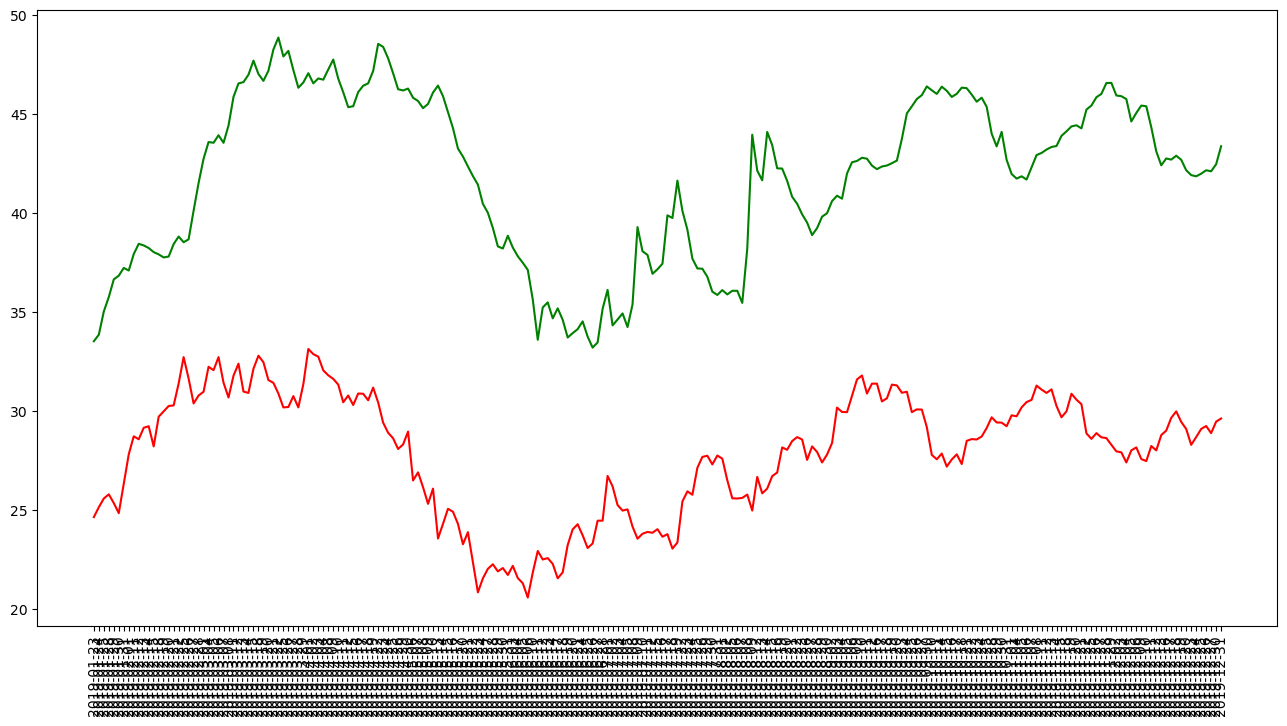

In [21]:
import matplotlib.pyplot as plt

df_time = df.index[-len(y_test):]
print(df_time)
plt.figure(figsize=(16,8))
plt.xticks(rotation='vertical')
plt.plot(df_time,y_test,color='red',label='price')
plt.plot(df_time,pre,color='green',label='price')
plt.show()